# Simulating a Diff Drive Robot with Unicycle Model

<img src="supportingMaterial/images/UnicycleWithDiffDrive.png" alt="Test Image" width="300" style="float: center"/>

Let's apply Unicycle Model to diff drive Robot and simulate a dead reckoning/ odometry based Localization

## System Dynamics
As we know, Model Kinematics for Unicycle model looks like

$\dot{X}$ = $f(x_r,y_r,\theta_r, v, \omega)$ 

$\dot{X} = \begin{pmatrix}
\dot{x_r} \\
\dot{y_r} \\
\dot{\theta_r}
\end{pmatrix}$ = $\begin{pmatrix} 
v \times \cos(\theta_r) \\
v \times \sin(\theta_r) \\
\omega
\end{pmatrix}$

## Equation for $v$ and $\omega$
In a differential drive model, Wheel angular velocities translates to $v$ and $\omega$ as follows
$v = \frac{r}{2} \times \omega_R + \frac{r}{2} \times \omega_L$

$\omega$ = $\frac{r}{d} \times \omega_R - \frac{r}{d} \times \omega_L$

Where,

$r$ = wheel radius

$d$ = distance between wheels

$\omega_R$ = Angular velocity given to Right Wheel

$\omega_L$ = Angular velocity given to Left Wheel


## State Transition
$x_t = x_{t-1} + v_t \cos(\theta_t) \times dt$

$y_t = y_{t-1} + v_t \sin(\theta_t) \times dt$

$\theta_t = \theta_{t-1} + \omega_t \times dt$

### Write the State Transition in the form of Matrices
For the given input
$U_t = \begin{pmatrix}
    \omega_R \\
    \omega_L
    \end{pmatrix}$

Express, state transition for the unicycle model in the form of:
$X_t = A X_{t-1} + B U_t$

You can use the latex form or you can choose to upload the picture with your solution
* For $X_t = A X_{t-1} + B U_t$:
    - $A = $
    - $B= $


In [81]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import math
import time

In [82]:
# Sim Params - You can choose to modify this
dt = 0.1
# Fixed params for Robot
r = 0.01 # Radius of Wheel
d = 0.5 # Distance between wheels

In [83]:
# Assume constant input - You can play around with this
omega_L = 11.0  # [rad/s]
omega_R = 10.0  # [rad/s]

In [84]:
def motion_model(x_t0,u):
    A = np.array([1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0]).reshape(4,4)
    omega_t = (r/d)*omega_R - (r/d)*omega_L
    vel_t = (r/2)*omega_R + (r/2)*omega_L
    theta_t0 = x_t0[2,0]
    theta_t1 = theta_t0 + (omega_t*dt)
    B = np.array([math.cos(theta_t1),0,math.sin(theta_t1),0,0,dt,1,0]).reshape(4,2)
    U_t = np.array([vel_t,omega_t]).reshape(2,1)
    X_t = np.dot(A,x_t0) + np.dot(B,U_t)
    return X_t

In [85]:
# You need not modify this function
def get_input():
    u = np.array([[omega_R], [omega_L]])
    return u

## Robot Axes
Let's also draw Robot Axes so that it gives sense of heading for a robot

Remember that Robot's x-axis on the body frame co-ordinate always points in front direction and y-axis to the left. This may not be true in global frame.

Hence, we have to transform the axes from body frame to global frame
Write the equation for how this can be done

Assume initial pose of Robot is (0,0,90 degrees)
Red represents the X-Axis and Green Represents the Y-axis. This is shown in the figure below

This means that Robot's Body frame axes at (0,0,0) are parallel to that of global frame

<img src="supportingMaterial/images/DiffDriveInitialPos.png" alt="Test Image" width="300" style="float: center"/>

In [86]:
def get_robot_axis(pose):
    # pose is a 4x1 column vector (x,y,theta,v)
    # Function should return a np.array of shape 2 x 4
    # Where first two columns gives co-ordinates of x-axis ([x1,y1],[x2,y2])
    # Next two columns gives co-ordinates of y-axis ([x1,y1],[x2,y2])
    
    # Axes co-ordinates for x and y axis in the Robot Body frame
    # Remember that these always remain the same in the body frame
    # Irrespective of Robot's pose
    # You don't have to change these values    
    x_body = np.array([[0, 1.0],[0,0]])
    y_body = np.array([[0,0],[0,1.0]])
    # Your Code Here
    x_pos = pose[0,0]
    y_pos = pose[1,0]
    thet_pos = pose[3,0]    
    axis_transformation = np.array([math.cos(thet_pos), (math.sin(-thet_pos)),math.sin(thet_pos),math.cos(thet_pos)]).reshape(2,2)
    x_body_transform = np.dot(x_body,axis_transformation)
    y_body_transform = np.dot(y_body,axis_transformation)
    robot_axis = np.hstack((x_body_transform,y_body_transform))
    return (robot_axis)
    

In [87]:
def checkTransformedAxes(axes):
    # Verify Axes should always be perpendicular - This is sanity check for the axes returned by your method
    dot_product = (axes[0,1] - axes[0,0]) * (axes[0,3] - axes[0,2]) + \
                  (axes[1,1] - axes[1,0]) * (axes[1,3] - axes[1,2])
    
    if abs(dot_product) > 1e-5:
        print("Non-zero dot product obtained: {}".format(dot_product))
        return False
    else:
        return True

In [88]:
# conda install -c conda-forge ipympl
%matplotlib widget

## Simulation

In [89]:
# Run this cell, to simulate the robot position for 200 seconds
t = 200.0
SIM_TIME = 1000.0 # You can reduce the time to debug

# State Vector [x y yaw v]'
X_dr = np.zeros((4, 1))
X_dr[2,0] = math.pi / 2

x_axes = np.zeros((2,2))
y_axes = np.zeros((2,2))

x_curr = X_dr
u = get_input()
while SIM_TIME >= t:
    x_next = motion_model(x_curr, u)
    X_dr = np.hstack((X_dr, x_next))
    axes = get_robot_axis(x_next)
    if not checkTransformedAxes(axes):
        print("Aborting Simulation, Transformed axes are not correct, please check")
        break
    x_axis_curr = axes[:,0:2]
    y_axis_curr = axes[:,2:4]
    x_axes = np.hstack((x_axes, x_axis_curr))
    y_axes = np.hstack((y_axes, y_axis_curr))
    x_curr = x_next
    t += dt

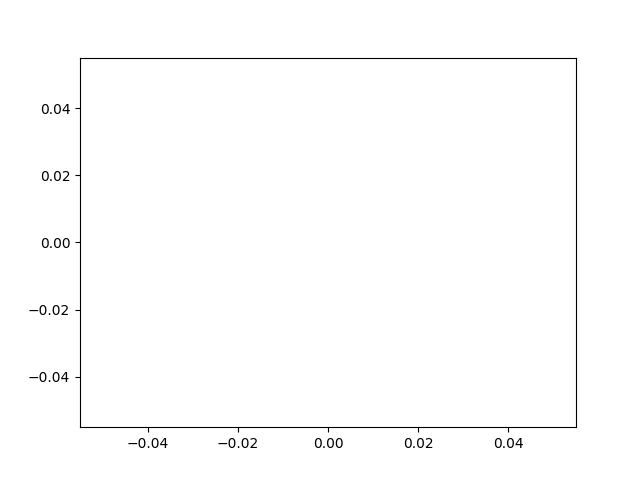

In [90]:
# Animate DR for Diff Drive Robot
# You just have to execute this cell
numFrames = 2000

fig, ax = plt.subplots()
dr_data, = plt.plot([],[],'-k', label='Dead Reckoning Traj')
x_axes_data, = plt.plot([],[],'-r', label='X-axis')
y_axes_data, = plt.plot([],[],'-g', label='Y-Axis')

frames=np.linspace(0, numFrames)
ind_dr = [(int)(frame * (X_dr.shape[1] - 1)/ numFrames) for frame in frames]
ind_ax = [(int)(frame * (x_axes.shape[1]- 2)/ numFrames) for frame in frames]

def init():
    x_dr = X_dr[0,:]
    y_dr = X_dr[1,:]
    
    if np.min(x_dr) < np.min(y_dr):
        min_val = np.min(x_dr)
    else:
        min_val = np.min(y_dr)
    
    if np.max(x_dr) > np.max(y_dr):
        max_val = np.max(x_dr)
    else:
        max_val = np.max(y_dr)
        
    min_x = np.min(x_dr) - 5
    ax.set_xlim([min_val - 5, max_val + 5])
    ax.set_ylim([min_val - 5, max_val + 5])
    plt.title("Dead Reckoning for a Unicycle Model with a Diff Drive Robot")
    plt.legend()
    ax.grid(True)
    return dr_data,x_axes_data,y_axes_data
    
def update(frameID):
    dr_data.set_data(X_dr[0,0:ind_dr[frameID]], X_dr[1,0:ind_dr[frameID]])
    x1 = x_axes[:,ind_ax[frameID]]
    x2 = x_axes[:,ind_ax[frameID] + 1]
    x_axes_data.set_data([x1[0], x2[0]],[x1[1], x2[1]])
    y1 = y_axes[:, ind_ax[frameID]]
    y2 = y_axes[:, ind_ax[frameID] + 1]
    y_axes_data.set_data([y1[0], y2[0]], [y1[1], y2[1]])
    return dr_data,

anim = FuncAnimation(fig, update, frames=numFrames-1, init_func=init, blit=True)
plt.show()